![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as pyplt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings

from datetime import timedelta
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
df = pd.read_feather('credit_scoring.ftr')

In [3]:
# Função que será usada abaixo para preencher os dados faltantes do 'tempo_emprego'
# com a média do tempo de emprego de quem possui 'tipo_renda' igual a Pensionista
# como já foi verificado nos exercícios anteriores que usaram essa mesma base

def preencher_na(fr: pd.DataFrame):
    media = fr.query('tipo_renda == "Pensionista"')['tempo_emprego'].mean()
    return fr.fillna(value={'tempo_emprego' : media})

In [4]:
# Função que será usada para categorizar os registros por uma faixa de tempo
# Pensionista em si não deveria ter tempo de emprego considerado, talvez por isso que originalmente estava Null
# No caso dessa coluna, será criada uma categoria de tempo 99 para indicar que se trata de pensionista

def categorizar_faixa_tempo(fr: pd.DataFrame):
    # cria um series com o tempo em inteiro
    tempo_series = np.round(fr['tempo_emprego'], 0)

    # recupera o maior e menor tempo e define o intervalo como o maior / 20
    tempo = tempo_series.describe()
    passo = tempo['max'] / 20
    ini = tempo['min']

    valores = []
    while (ini < tempo['max']):
        fim = np.round(ini + passo + 0.01, 2)
        valores.append(pd.Interval(left=ini, right=fim, closed='left'))
        ini = fim

    fr['tempo_emprego_int'] = tempo_series

    def aplicar_faixa(x):
        for faixa in valores:
            if x in faixa:
                return faixa
        return None

    fr['tempo_emprego_faixa'] = fr['tempo_emprego_int'].apply(aplicar_faixa)
    fr.drop(columns=['tempo_emprego_int'], inplace=True)

    # para quem é Pensionista, será criada uma faixa de tempo "fake" cujo valor é 99
    # indicando que se trata de Pensionista
    index = fr.query('tipo_renda=="Pensionista"').index
    fr.loc[index, 'tempo_emprego_faixa'] = pd.Interval(left=99, right=99, closed='both')

    fr['tempo_emprego_faixa'] = pd.Categorical(fr['tempo_emprego_faixa'])
    return fr

In [5]:
# Função para categorizar as variáveis

def categorizar_variaveis(fr: pd.DataFrame):
    fr['sexo'] = pd.Categorical(fr['sexo'])
    fr['posse_de_veiculo'] = pd.Categorical(fr['posse_de_veiculo'])
    fr['posse_de_imovel'] = pd.Categorical(fr['posse_de_imovel'])
    fr['tipo_renda'] = pd.Categorical(fr['tipo_renda'])
    fr['educacao'] = pd.Categorical(fr['educacao'])
    fr['estado_civil'] = pd.Categorical(fr['estado_civil'])
    fr['tipo_residencia'] = pd.Categorical(fr['tipo_residencia'])
    fr['mau'] = df['mau'].astype('int')
    fr['idade_faixa'] = pd.qcut(fr['idade'], 5, duplicates='drop')
    fr['idade_faixa'] = pd.Categorical(fr['idade_faixa'])
    return fr

In [6]:
# Rodando todas as transformações nos dados do Dataframe

df = (
    df.drop(columns=['index'])

    # Preenche os dados faltantes
    .pipe(preencher_na)

    # categorizando por faixa de tempo.
    .pipe(categorizar_faixa_tempo)

    # categorizar variáveis
    .pipe(categorizar_variaveis)

    # cria uma coluna com o log da renda (Y)
    .assign(renda_log = lambda x: np.log(x['renda']))
)

In [7]:
df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tempo_emprego_faixa,idade_faixa,renda_log
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0,"[6.48, 8.64)","(40.0, 47.0]",7.830183
1,2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0,"[4.32, 6.48)","(33.0, 40.0]",8.064696
2,2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0,"[0.0, 2.16)","(21.999, 33.0]",7.366628
3,2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0,"[12.96, 15.12)","(47.0, 55.0]",9.526695
4,2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0,"[6.48, 8.64)","(21.999, 33.0]",7.969385


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [8]:
data_corte = df.data_ref.max() - timedelta(days=90)
df_teste  = df.query('data_ref >= @data_corte')
df_treino = df.query('data_ref  < @data_corte')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

### Descreva a base quanto ao número de linhas, número de linhas para cada mês em data_ref

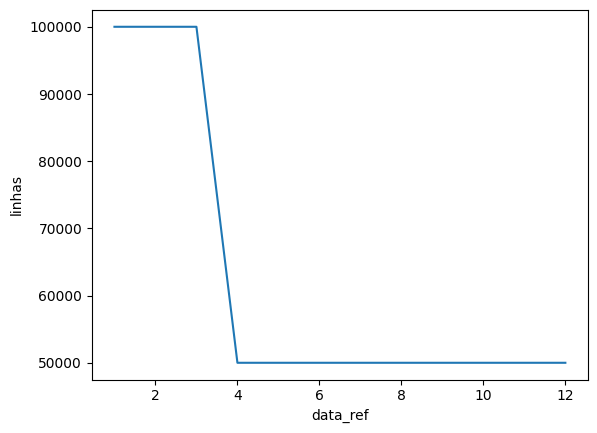

In [9]:
ln_mes = pd.DataFrame(df.groupby(df['data_ref'].dt.month).size(), columns=['linhas'])
sns.lineplot(x=ln_mes.index, y=ln_mes['linhas']);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A base de dados possui 100.000 registros para cada um dos 3 primeiros registros do ano e 50.000 registros para todos os outros meses do ano.
    
</div>

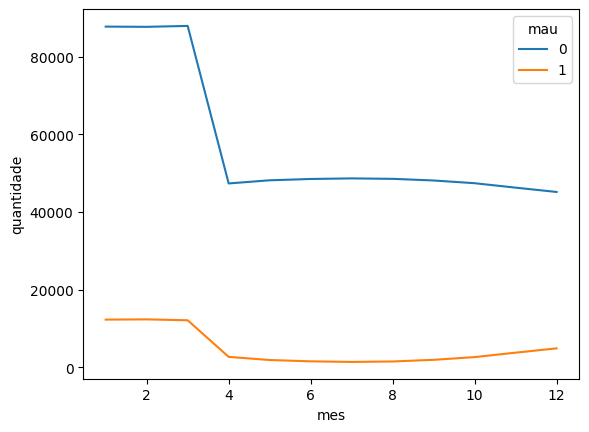

In [10]:
ln_mau = pd.DataFrame({
    "mes": df['data_ref'].dt.month,
    "mau": df['mau']
}).groupby(['mes', 'mau']).size().reset_index().rename(columns={0: "quantidade"})

sns.lineplot(data=ln_mau, x='mes', y='quantidade', hue='mau');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O gráfico acima também exibe a quantidade de registros para cada mês do ano, mas separando entre bons e maus. Podemos verificar que existe uma tendência do aumento do número de maus no final do ano. Separando a base de teste com os 3 últimos messes do ano, como pede o enunciado, a base de teste irá refletir essa tendência, enquanto a base de treinamento não.
    
</div>

###  Descritiva básica univariada de cada variável

**Variáveis `posse_de_veiculo`, `posse_de_imovel`, `sexo` e `mau`**

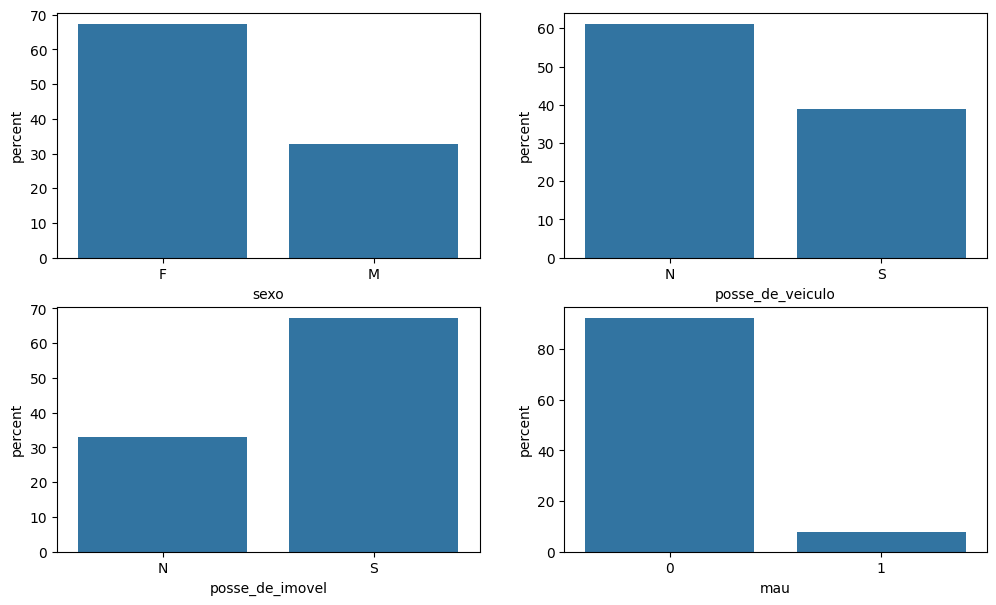

In [11]:
fig, ax = pyplt.subplots(2,2, figsize=(12,7))
sns.countplot(ax=ax[0][1], stat='percent', x=df['posse_de_veiculo'])
sns.countplot(ax=ax[1][0], stat='percent', x=df['posse_de_imovel'])
sns.countplot(ax=ax[0][0], stat='percent', x=df['sexo'])
sns.countplot(ax=ax[1][1], stat='percent', x=df['mau']);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Variável **`sexo`**: Podemos verificar que existe praticamente o dobro de registro do sexo feminino.
    
Variável **`posse_de_veiculo`**: A base está dividida em 60% que não possuem carro e 40% que possuem.
    
Variável **`posse_de_imovel`**: A base possui o dobro de registros de pessoas que possuem imóvel em relação a quem não possui.
    
Variável **`mau`**: Apenas 10% dos registros da base são de maus
    
</div>

**Variáveis `qtd_filhos` e `qt_pessoas_residencia`**

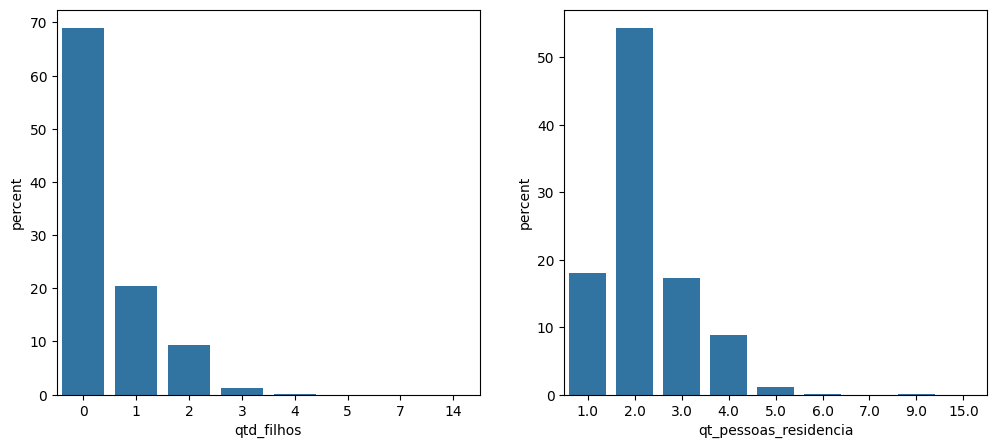

In [12]:
fig, ax = pyplt.subplots(1,2, figsize=(12,5))
sns.countplot(ax=ax[0], stat='percent', x=df['qtd_filhos'])
sns.countplot(ax=ax[1], stat='percent', x=df['qt_pessoas_residencia']);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Variável **`qtd_filhos`**: Podemos verificar que a maioria dos registros são de pessoas que não possuem filhos. Também podemos ver que praticamente toda a base é composta por pessoas que possuem até 2 filhos. Chama atenção os registros com mais de 5 filhos.
    
Variável **`qt_pessoas_residencia`**: A maioria dos registros são referentes a 2 pessoas morando na mesma residência. A quase totalidade dos registros nessa variável são de até 3 pessoas por residência.
    
</div>

**Variáveis `tipo_renda`, `educacao`, `estado_civil` e `tipo_residencia`**

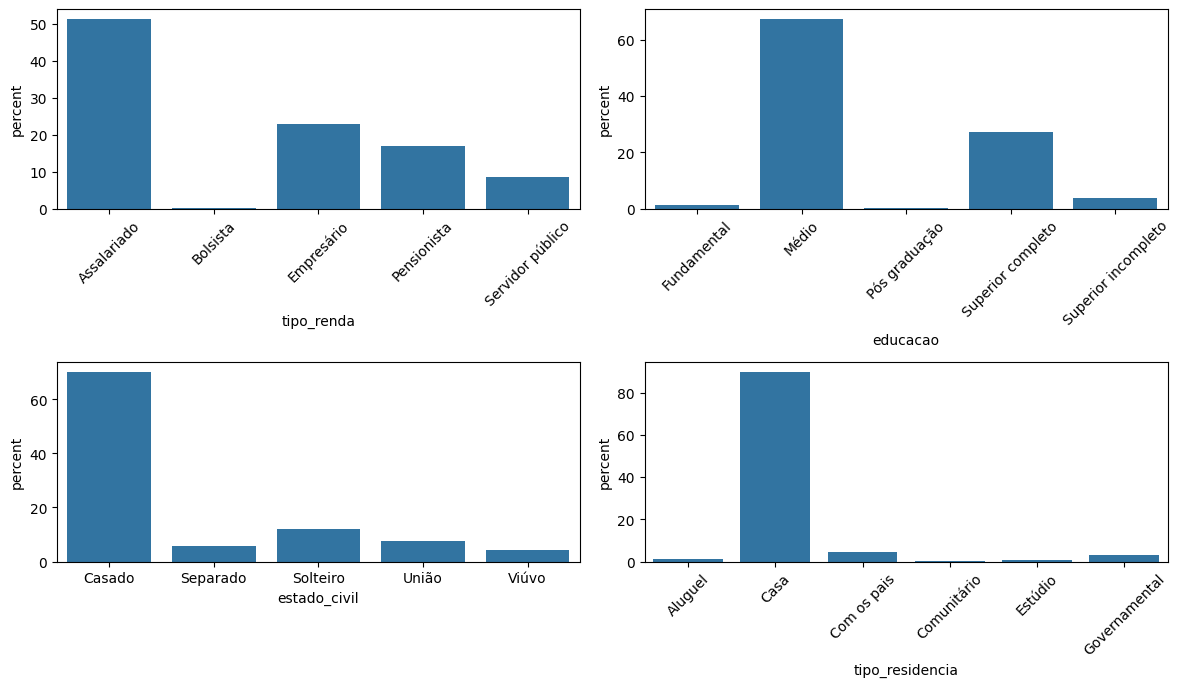

In [13]:
fig, ax = pyplt.subplots(2,2, figsize=(12,7))
sns.countplot(ax=ax[0][0], stat='percent', x=df['tipo_renda'])
sns.countplot(ax=ax[0][1], stat='percent', x=df['educacao'])
sns.countplot(ax=ax[1][0], stat='percent', x=df['estado_civil'])
sns.countplot(ax=ax[1][1], stat='percent', x=df['tipo_residencia'])

ax[0][0].tick_params(axis='x', labelrotation=45)
ax[0][1].tick_params(axis='x', labelrotation=45)
ax[1][1].tick_params(axis='x', labelrotation=45)

pyplt.tight_layout()

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Variável **`tipo_renda`**: Podemos verificar que a maioria dos registros são de Assalariados. Chama atenção a baixíssima quantidade de registros para Bolsistas.
    
Variável **`educacao`**: A base é formada praticamente por apenas registros de pessoas com ensino médio e superior, considerando aqui completo e incompleto.

Variável **`tipo_residencia`**: Mais de 80% dos registros são de pessoas que moram em casa. Chama atenção para a baixa quantidade de registros do tipo Comunitário e Estúdio.
    
Variável **`estado_civil`**: Mais de 60% dos registros são de pessoas casadas. Os outros quase 40% estão distribuídos entre os outros estados civis.
    
</div>

**Variável `idade`**

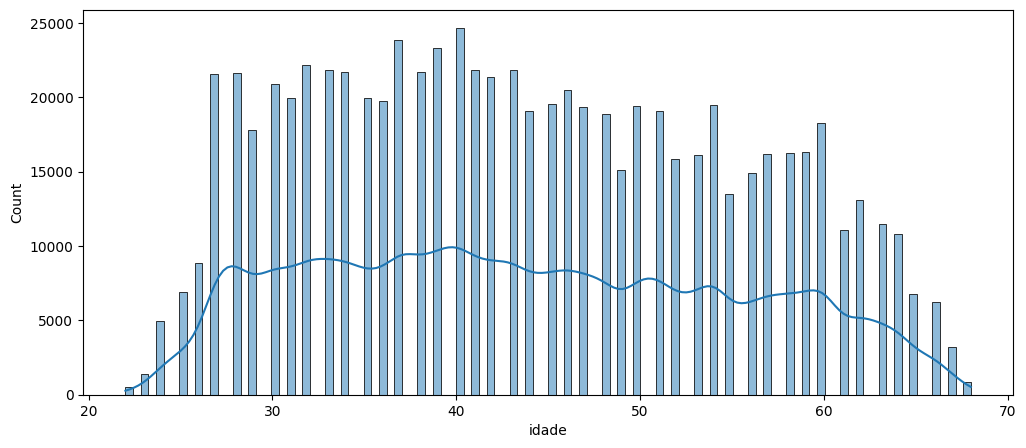

In [14]:
fig, ax = pyplt.subplots(1,1, figsize=(12,5))
sns.histplot(ax=ax, x=df['idade'], kde=True);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A maioria dos registros são de pessoas entre 27 a 65 anos de idade
    
</div>

**Variável `tempo_emprego_faixa`**

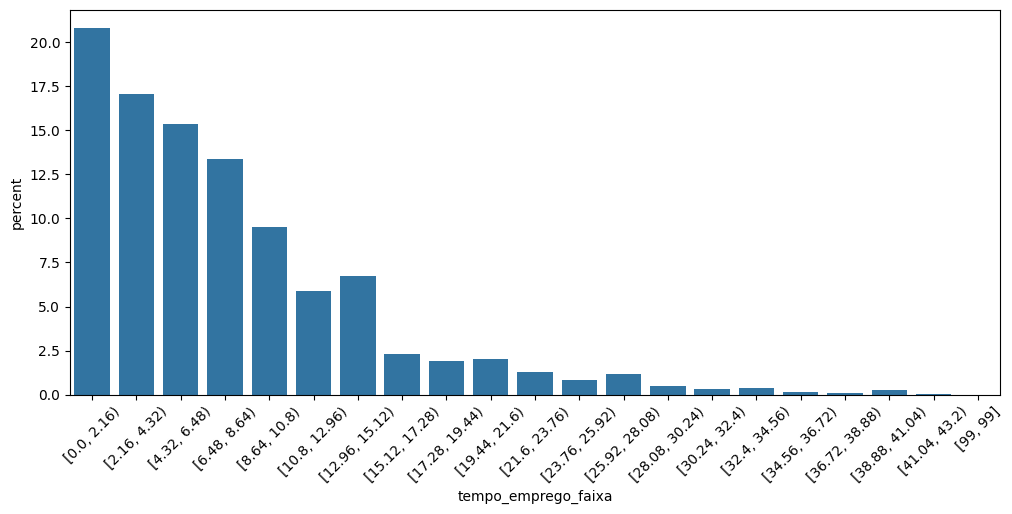

In [15]:
fig, ax = pyplt.subplots(1,1, figsize=(12,5))
c = sns.countplot(ax=ax, x='tempo_emprego_faixa', stat='percent', data=df.query('tipo_renda != "Pensionista"'))
c.tick_params(axis='x', labelrotation=45);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A base é composta majoritariamente por registros de pessoas com até 15 anos de emprego. O gráfico acima descarta os registros dos Pensionistas, que não possuem tempo de emprego definido na base.
    
</div>

**Variável `renda_log`**

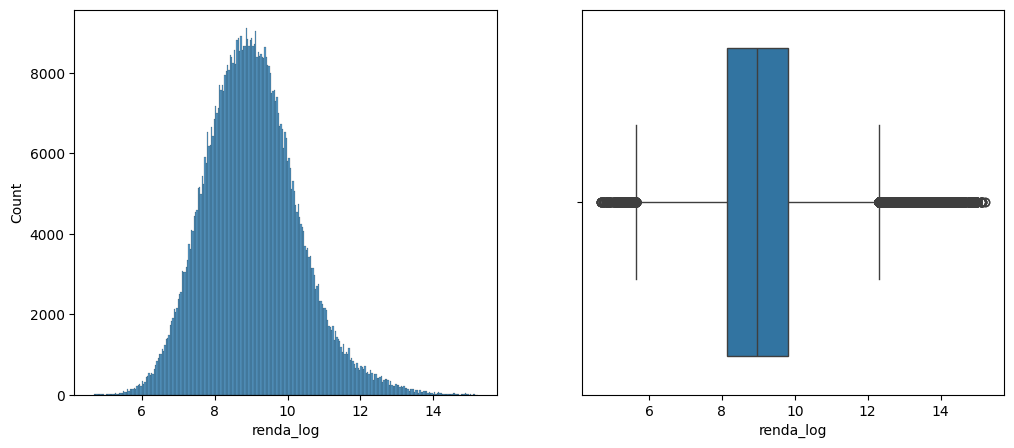

In [16]:
fig, ax = pyplt.subplots(1,2, figsize=(12,5))
sns.histplot(ax=ax[0], x=df['renda_log'])
sns.boxplot( ax=ax[1], x=df['renda_log']);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos ver que a renda tende a uma curva normal, mas que possuem uma série de outliers e que não está centrada na média.
    
</div>

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [17]:
# Função para o cálculo do Information Value

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [18]:
# Função para criar o gráfico do WOE para variáveis contínuas

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau':g['mau'].mean(),
        var: g[var].mean(),
        'cont':g[var].count()
    })

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = pyplt.subplots(1,1, figsize=(9,4))
    ax.plot(biv[var], biv.woe, ':bo', label='woe')
    ax.plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax.set_ylabel("Weight of Evidence: " + var)
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    return None

In [19]:
# Função para criar o gráfico do WOE para variáveis discretas

def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau':g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont':g[var].count()
    })

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = pyplt.subplots(1,1, figsize=(9,4))
    var_list = biv[var]

    if (str(df[var].dtype) == 'category'):
        var_list = var_list.astype('str')

    ax.plot(var_list, biv.woe, ':bo', label='woe')
    ax.plot(var_list, biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(var_list, biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax.set_xlim([-.3, num_cat-.7])

    ax.set_ylabel("Weight of Evidence: " + var)
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax.set_xticks(list(range(num_cat)))
    ax.set_xticklabels(biv[var], rotation=25)

    return biv

In [20]:
# Função para criar no DataFrame uma coluna com a classificação do IV de acordo com Siddiqi

def siddiqi_class(x):
    if np.isnan(x):
        return float("NAN")
    n = x*10
    if n < 0.02:
        return 'Inútil'
    elif (n >= 0.02) & (n < 0.1):
        return 'Fraco'
    elif (n >= 0.1) & (n < 0.3):
        return 'Médio'
    elif (n >= 0.3) & (n < 0.5):
        return 'Forte'
    else:
        return 'Suspeito'

In [21]:
# função que retorna os valores distintos de cada coluna do DataFrame passado por parâmetro
def verificar_valores_por_coluna(df_ref) -> pd.DataFrame:
    cl = list(df_ref.select_dtypes(include=['object', 'category', 'int64']).columns) + ['qt_pessoas_residencia']
    colunas_df = []; valores_df = [];
    for col in cl:
        valor_coluna = df_ref[col].unique()
        valor_coluna = map(lambda x: str(x), valor_coluna)
        valor_coluna = ", ".join(list(valor_coluna))
        colunas_df.append(col)
        valores_df.append(valor_coluna)

    return pd.DataFrame({'Coluna': colunas_df, 'Valores': valores_df})

In [22]:
# cria um novo DataFrame com o metadados das variáveis

metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados.drop(index=['data_ref', 'tempo_emprego', 'renda'], inplace=True)
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

In [23]:
# calcula o IV para todas as variáveis

for var in metadados[metadados.papel == 'covariavel'].index:
    check = (metadados.loc[var, 'dtype'] in {np.dtype('float64'), np.dtype('int64')})
    if  (check and metadados.loc[var, 'valores_unicos'] > 6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

In [24]:
# aplica a classificação do IV de acordo com Siddiqi

metadados['classificacao'] = metadados['IV'].apply(siddiqi_class)

In [25]:
metadados

,dtype,nmissing,valores_unicos,papel,IV,classificacao
sexo,category,0,2,covariavel,0.002185,Fraco
posse_de_veiculo,category,0,2,covariavel,0.000108,Inútil
posse_de_imovel,category,0,2,covariavel,0.009693,Fraco
qtd_filhos,int64,0,8,covariavel,0.000030,Inútil
tipo_renda,category,0,5,covariavel,0.009360,Fraco
educacao,category,0,5,covariavel,0.003547,Fraco
estado_civil,category,0,5,covariavel,0.001126,Inútil
tipo_residencia,category,0,6,covariavel,0.003045,Fraco
idade,int64,0,47,covariavel,0.017968,Médio
qt_pessoas_residencia,float64,0,9,covariavel,0.001346,Inútil


**Variável `sexo`**

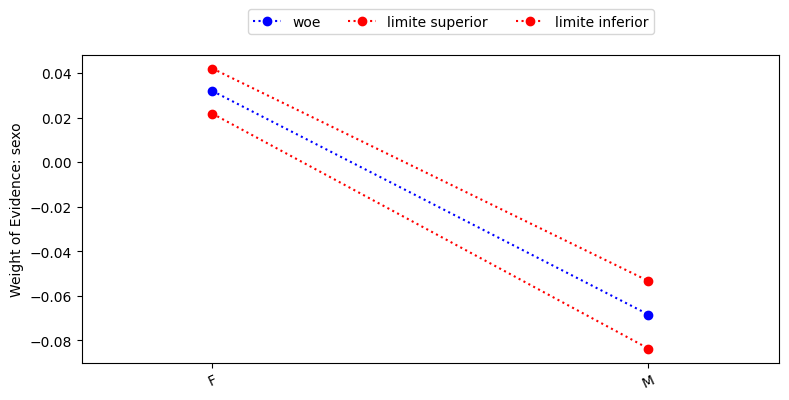

In [26]:
biv_discreta('sexo', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Em valores absolutos, a variável possui um peso maior para o sexo masculino, apesar de existirem menos dados para essa categoria.
</div>

**Variável `posse_de_veiculo`**

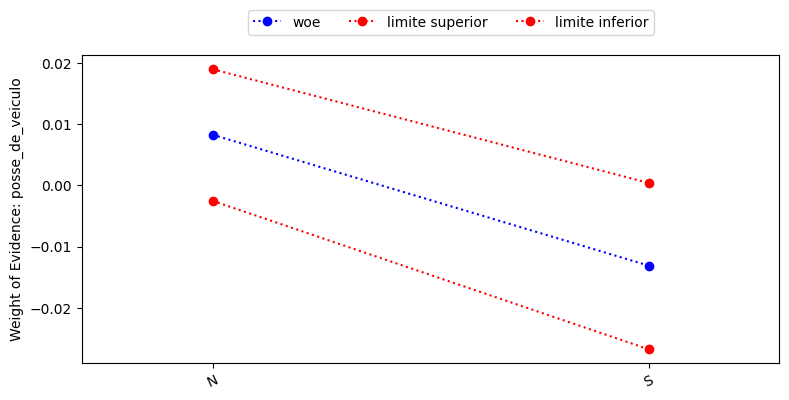

In [27]:
biv_discreta('posse_de_veiculo', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Em valores absolutos essa variável não apresenta nenhuma variação entre as 2 categorias.


</div>

**Variável `posse_de_imovel`**

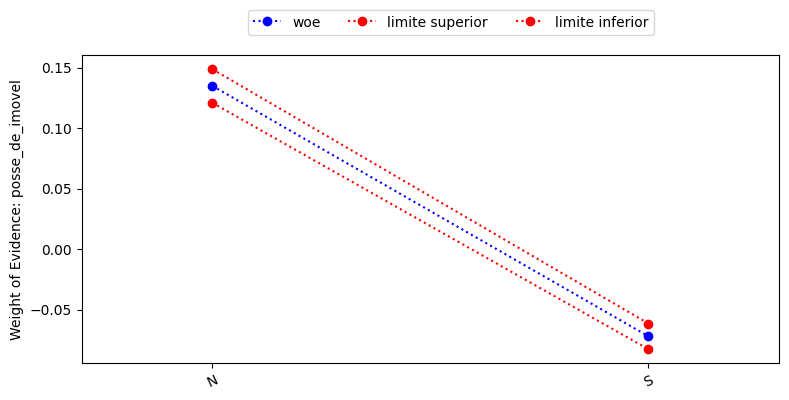

In [28]:
biv_discreta('posse_de_imovel', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Como verificado anteriormente na análise univariada, a quantidade de registros que possuem imóvel de quase 70%. Podemos ver acima que a categoria possui imóvel não apresenta uma variação significante em relação a quem não possui.




</div>

**Variável `qtd_filhos`**

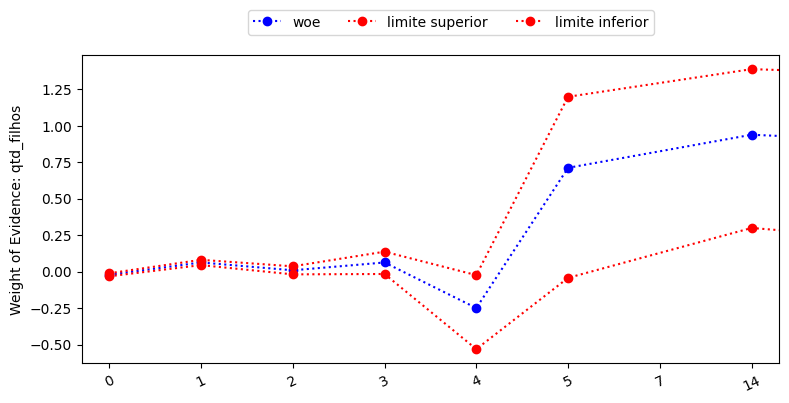

In [29]:
biv_discreta('qtd_filhos', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar que essa variável possui uma variação quanto ao peso até a quantidade 3. A partir do 5 há uma variação muito grande no peso. Abaixo será analisado os dados da base para as quantidades 5, 7 e 14.





</div>

In [30]:
verificar_valores_por_coluna(df.query('qtd_filhos == 14'))

,Coluna,Valores
0,sexo,M
1,posse_de_veiculo,S
2,posse_de_imovel,S
3,qtd_filhos,14
4,tipo_renda,Assalariado
5,educacao,Médio
6,estado_civil,Separado
7,tipo_residencia,Casa
8,idade,48
9,mau,"1, 0"


In [31]:
verificar_valores_por_coluna(df.query('qtd_filhos == 7'))

,Coluna,Valores
0,sexo,F
1,posse_de_veiculo,N
2,posse_de_imovel,N
3,qtd_filhos,7
4,tipo_renda,Assalariado
5,educacao,Médio
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,37
9,mau,"1, 0"


In [32]:
verificar_valores_por_coluna(df.query('qtd_filhos == 5'))

,Coluna,Valores
0,sexo,"F, M"
1,posse_de_veiculo,"N, S"
2,posse_de_imovel,S
3,qtd_filhos,5
4,tipo_renda,Assalariado
5,educacao,Médio
6,estado_civil,"Separado, Casado"
7,tipo_residencia,"Casa, Comunitário"
8,idade,"42, 31"
9,mau,"0, 1"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Sobre as quantidades 7 e 14, considerando as variáveis sexo, tipo_renda, educacao, estado_civil, tipo_residencia e idade, podemos afirmar que todos os registros relacionados a essas quantidades são de praticamente o mesmo indivíduo, com essas mesmas características.

Sobre a quantidade 5, os dados parecem normais, mas cabe uma análise sobre o estado_civil e tipo_residencia relacionados.







</div>

**Variável `tipo_renda`**

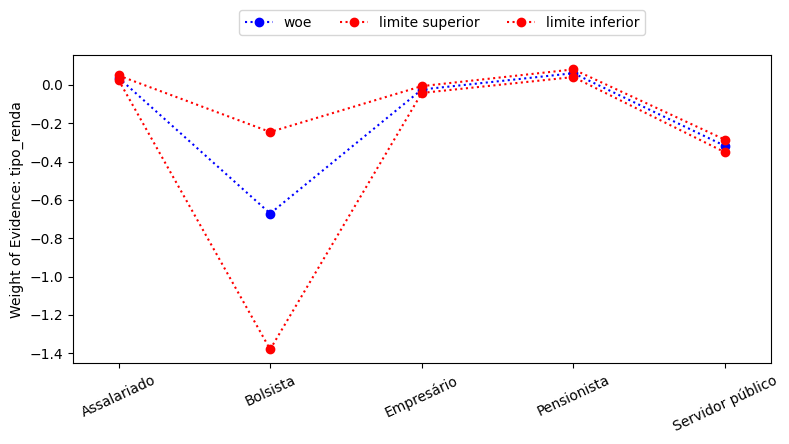

In [33]:
biv_discreta('tipo_renda', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Existe uma discrepância da categoria Bolsista em relação aos demais


</div>

In [34]:
verificar_valores_por_coluna(df.query('tipo_renda == "Bolsista"'))

,Coluna,Valores
0,sexo,F
1,posse_de_veiculo,N
2,posse_de_imovel,S
3,qtd_filhos,0
4,tipo_renda,Bolsista
5,educacao,Superior completo
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,51
9,mau,"0, 1"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Analisando os dados distintos das outras variáveis relacionadas ao Bolsista, também podemos ver que são todos iguais, ou seja, todos os registros possuem as mesmas características. O tipo Bolsista pode ser removido.




</div>

**Variável `educacao`**

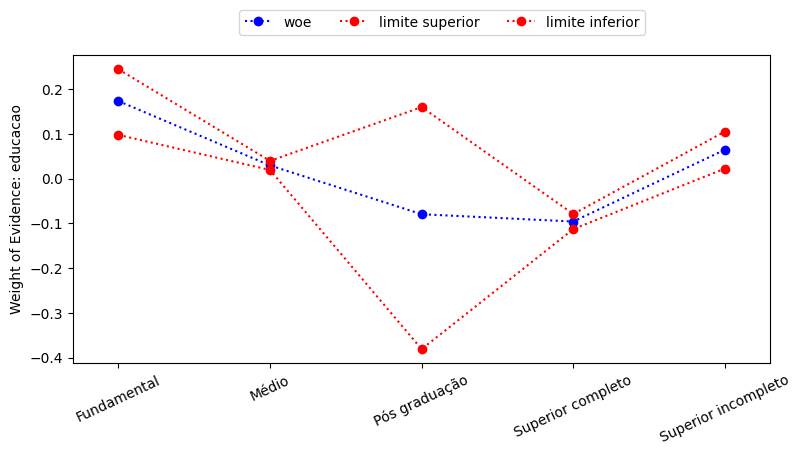

In [35]:
biv_discreta('educacao', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar uma grande variação no tipo Pós graduação. Podemos pensar em agrupar os dados de Pós-graduação, Superior incompleto e Superior completo. Esse teste será feiro abaixo.






</div>

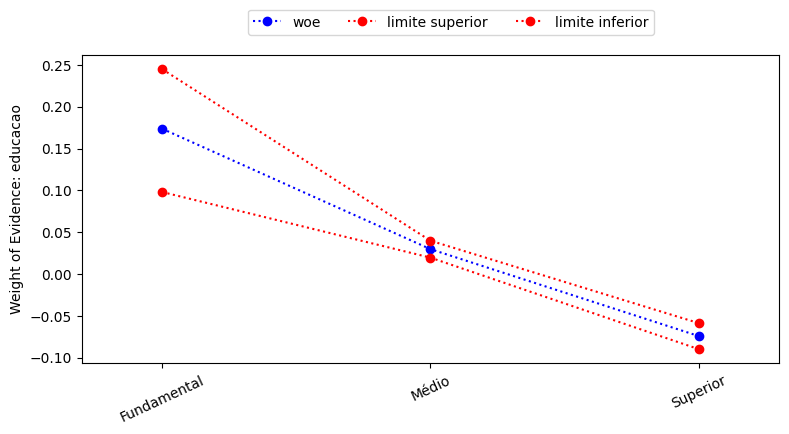

In [36]:
cp = df.copy()
cp['educacao'].replace({
    'Superior incompleto': 'Superior',
    'Superior completo': 'Superior',
    'Pós graduação': 'Superior'
}, inplace=True)
biv_discreta('educacao', cp); cp = None

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Após o agrupamentos dos 3 tipos de níveis, o peso entre as categorias ficou melhor distribuído.




</div>

**Variável `estado_civil`**

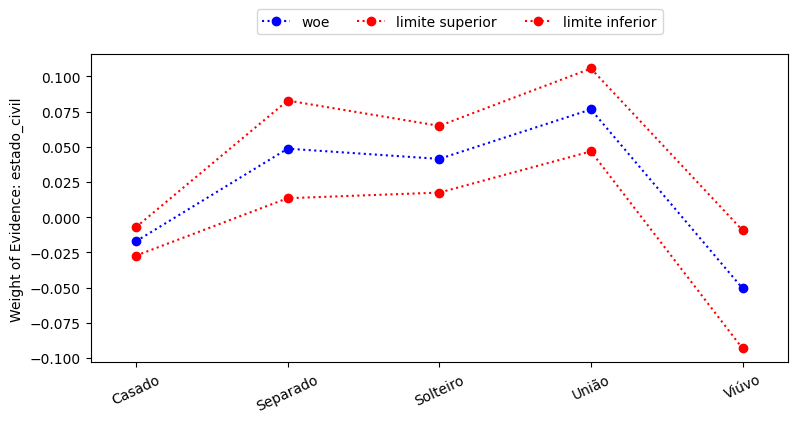

In [37]:
biv_discreta('estado_civil', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos observar que existe pouca variação para o tipo Casado e uma grande variação entre os Viúvos. Talvez pudessemos juntar o tipo Separado com Solteiro e União com Casado. Esse teste será feito abaixo.




</div>

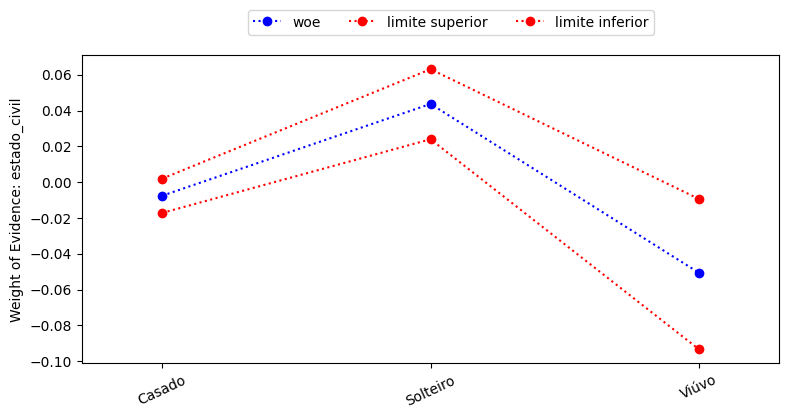

In [38]:
cp = df.copy()
cp['estado_civil'].replace({
    'Separado': 'Solteiro',
    'União': 'Casado'
}, inplace=True)
biv_discreta('estado_civil', cp);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Com essa alteração, a variação do tipo casado foi mantida e foi reduzida para o tipo Solteiro. A variação para o tipo Viúvo se mantém, pois não é possível juntar esses dados com nenhum outro tipo.



</div>

**Variável `tipo_residencia`**

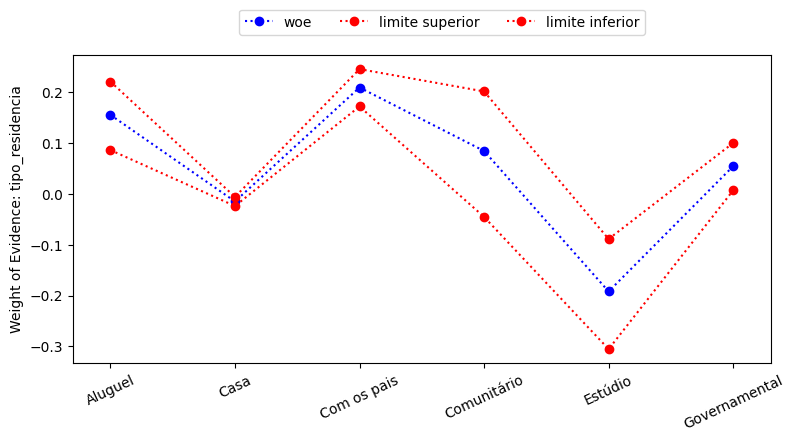

In [39]:
biv_discreta('tipo_residencia', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Podemos ver que existem variações em todos os tipos, exceto Casa, que também possui o maior volume de dados. Talvez o tipo de residência do indivíduo não seja relevando para previsão da renda ou se ele é bom ou mau pagador. Talvez o importante nesse caso seja definir se o indivíduo possui ou não alguma despesa com o local onde reside. Abaixo será criada uma nova variável para realizar esse teste, considerando que quem possui despesa com o local onde mora são os tipos 'Aluguel', 'Comunitário' e 'Estúdio'.



</div>

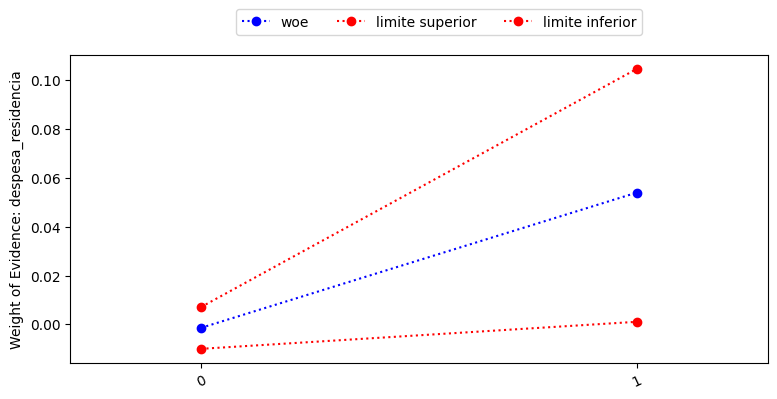

In [40]:
df['despesa_residencia'] = np.where(df['tipo_residencia'].isin(['Aluguel', 'Comunitário', 'Estúdio']), 1, 0)
biv_discreta('despesa_residencia', df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Ainda assim temos uma variação considerável, mas inferior aos tipos individuais como anteriormente.





</div>

**Variável `qt_pessoas_residencia`**

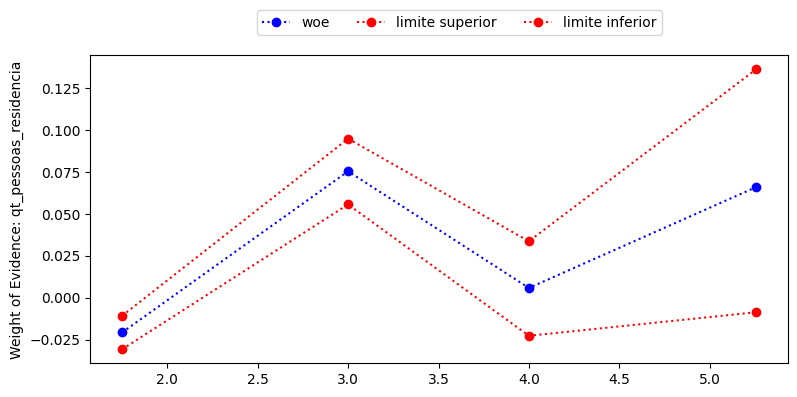

In [41]:
biv_continua('qt_pessoas_residencia', 10, df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Aqui podemos ver que existem variações em todas as quantidades, exceto com 1 pessoa. Talvez essa variável não seja tao relevante porque todas as pessoas na residência podem ter alguma renda e não necessariamente uma pessoa da residência que sustenta a família.





</div>

**Variável `tempo_emprego`**

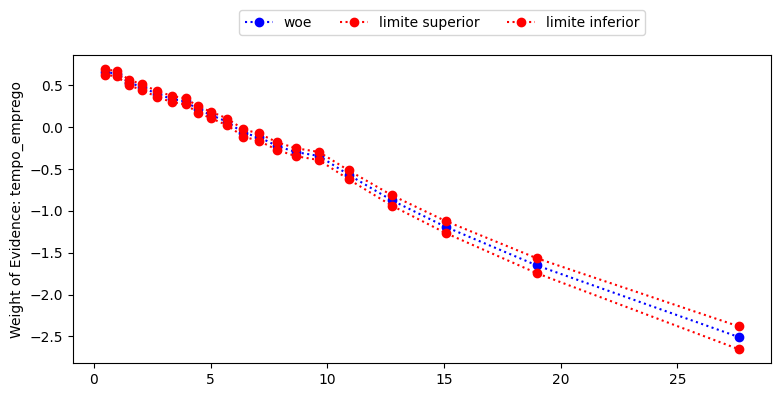

In [42]:
biv_continua('tempo_emprego', 20, df.query('tipo_renda != "Pensionista"').copy());

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Podemos observar que os dados apresentam uma variação maior a partir de 13 ano de emprego.





</div>

**Variável `idade`**

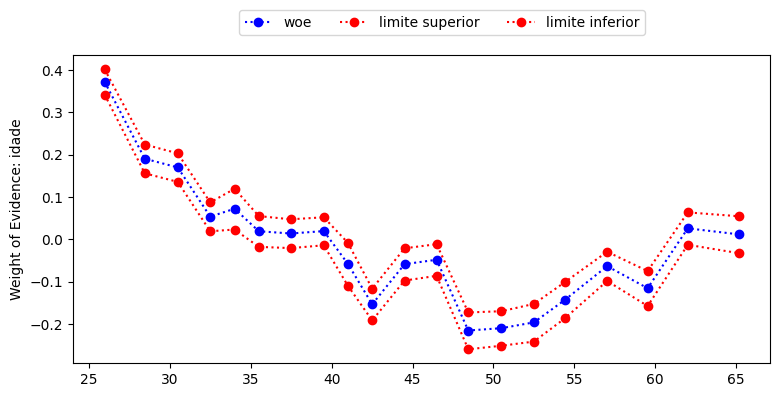

In [43]:
biv_continua('idade', 20, df);

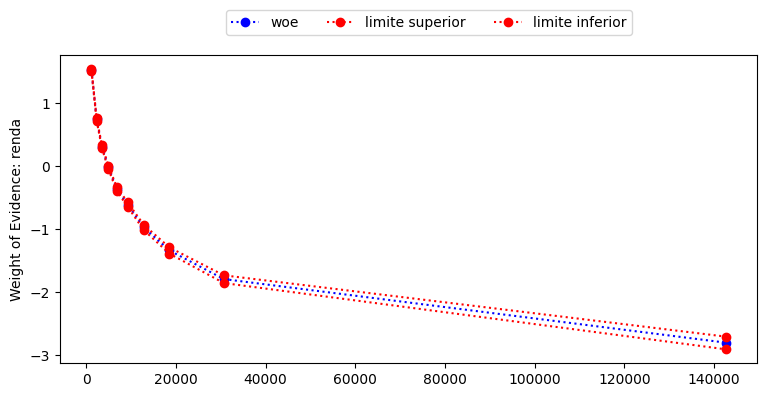

In [44]:
biv_continua('renda', 10, df);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
Podemos observar que os dados apresentam uma grande variação a partir de 20.000 de renda





</div>

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [49]:
base = df.copy()

base.drop(base.query('qtd_filhos >= 5').index, inplace=True);
base.drop(base.query('tipo_renda == "Bolsista"').index, inplace=True);

base['educacao'].replace({
    'Superior incompleto': 'Superior',
    'Superior completo': 'Superior',
    'Pós graduação': 'Superior'
}, inplace=True)

base['estado_civil'].replace({
    'Separado': 'Solteiro',
    'União': 'Casado'
}, inplace=True)

base['renda_faixa'] = pd.qcut(base['renda_log'], 11, duplicates='drop')
base['renda_faixa'] = pd.Categorical(base['renda_faixa'])
base['despesa_residencia'] = np.where(base['tipo_residencia'].isin(['Aluguel', 'Comunitário', 'Estúdio']), 1, 0)

base['tipo_renda'] = base['tipo_renda'].cat.remove_unused_categories()
base['educacao'] = base['educacao'].cat.remove_unused_categories()
base['estado_civil'] = base['estado_civil'].cat.remove_unused_categories()

base.reset_index(inplace=True)

In [50]:
# O código abaixo lista o valor mais frequente para cada variável categórica
# esse valor será usado como casela de referência

for col in base.select_dtypes(include=['object', 'category']).columns:
    maior_valor = base[col].value_counts().sort_values(ascending=False).index[0]
    print(f"Coluna {col}: {maior_valor}")

Coluna sexo: F
Coluna posse_de_veiculo: N
Coluna posse_de_imovel: S
Coluna tipo_renda: Assalariado
Coluna educacao: Médio
Coluna estado_civil: Casado
Coluna tipo_residencia: Casa
Coluna tempo_emprego_faixa: [0.0, 2.16)
Coluna idade_faixa: (21.999, 33.0]
Coluna renda_faixa: (10.122, 10.736]


In [58]:
variaveis_modelo = [
    "C(sexo, Treatment('F'))",
    "C(posse_de_imovel, Treatment('S'))",
    "C(tipo_renda, Treatment('Assalariado'))",
    "C(educacao, Treatment('Médio'))",
    "C(estado_civil, Treatment('Casado'))",
    "idade",
    "qtd_filhos",
    "tempo_emprego_faixa",
    "renda_faixa",
]

In [59]:
data_corte = base.data_ref.max() - timedelta(days=90)
df_teste  = base.query('data_ref >= @data_corte')
df_treino = base.query('data_ref  < @data_corte')

In [60]:
formula = 'mau ~ ' + ' + '.join(variaveis_modelo)
rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               599479
Model:                            GLM   Df Residuals:                   599438
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2072e+05
Date:                Sun, 07 Apr 2024   Deviance:                   2.4145e+05
Time:                        17:10:43   Pearson chi2:                 5.98e+05
No. Iterations:                    25   Pseudo R-squ. (CS):            0.05536
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.0131      0.035    -29.240      0.000      -1.081      -0.945
C(sexo, Treatment('F'))[T.M]                                    -0.0130      0.013     -1.026      0.305      -0.038       0.012
C(posse_de_imovel, Treatment('S'))[T.N]                          0.0309      0.012      2.615      0.009       0.008       0.054
C(tipo_renda, Treatment('Assalariado'))[T.Empresário]           -0.0098      0.014     -0.689      0.491      -0.038       0.018
C(tipo_renda, Treatment('Assalariado'))[T.Pensionista]          -0.0174      0.011     -1.556      0.120      -0.039       0.005
C(tipo_renda, Treatment('Assalariado'))[T.Servidor público]     -0.0041      0.024     -0.176      0.860      -0.050       0.042
C(educacao, Treatment('Médio'))[T.Fundamental]                  -0.0082      0.050     -0.165      0.869      -0.105       0.089
C(educacao, Treatment('Médio'))[T.Superior]                     -0.0079      0.013     -0.617      0.537      -0.033       0.017
C(estado_civil, Treatment('Casado'))[T.Solteiro]                -0.0001      0.015     -0.007      0.994      -0.029       0.029
C(estado_civil, Treatment('Casado'))[T.Viúvo]                   -0.0226      0.029     -0.768      0.442      -0.080       0.035
tempo_emprego_faixa[T.Interval(2.16, 4.32, closed='left')]      -0.0123      0.017     -0.729      0.466      -0.045       0.021
tempo_emprego_faixa[T.Interval(4.32, 6.48, closed='left')]       0.0001      0.019      0.007      0.995      -0.036       0.037
tempo_emprego_faixa[T.Interval(6.48, 8.64, closed='left')]      -0.0611      0.022     -2.836      0.005      -0.103      -0.019
tempo_emprego_faixa[T.Interval(8.64, 10.8, closed='left')]      -0.0271      0.026     -1.034      0.301      -0.079       0.024
tempo_emprego_faixa[T.Interval(10.8, 12.96, closed='left')]     -0.0171      0.037     -0.466      0.641      -0.089       0.055
tempo_emprego_faixa[T.Interval(12.96, 15.12, closed='left')]    -0.1464      0.042     -3.447      0.001      -0.230      -0.063
tempo_emprego_faixa[T.Interval(15.12, 17.28, closed='left')]    -0.0815      0.078     -1.047      0.295      -0.234       0.071
tempo_emprego_faixa[T.Interval(17.28, 19.44, closed='left')]    -0.3063      0.100     -3.058      0.002      -0.503      -0.110
tempo_emprego_faixa[T.Interval(19.44, 21.6, closed='left')]      0.0586      0.093      0.630      0.529      -0.124       0.241
tempo_emprego_faixa[T.Interval(21.6, 23.76, closed='left')]     -0.1311      0.144     -0.912      0.362      -0.413       0.151
tempo_emprego_faixa[T.Interval(23.76, 25.92, closed='left')]    -0.3363      0.205     -1.640      0.101      -0.738

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [62]:
df2 = df_teste.copy()
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 41.5% 
AUC: 72.6% 
GINI: 45.2%
KS: 34.0%
